In [ ]:
!pip install -q protobuf==3.20.3

In [4]:
!pip install -q monai[all] nibabel scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 33.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 MB 20.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 26.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 62.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 31.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.5/28.5 MB 65.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 84.6 MB/s eta

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path
import random
from tqdm import tqdm
import gc
import cv2
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score

# Install MONAI if needed


from monai.networks.nets import UNet, SegResNet
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric

In [8]:
CONFIG = {
    'data_path': '/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE',
    'image_size': (512, 512),
    'batch_size': 4,
    'num_epochs': 50,
    'learning_rate': 1e-3,
    'val_interval': 2,
    'model_type': 'UNet',  # Change to 'SegResNet' to try different model
    'use_subset': False,
}

print("="*80)
print(f"DRIVE RETINAL VESSEL SEGMENTATION - {CONFIG['model_type']}")
print("="*80)

DRIVE RETINAL VESSEL SEGMENTATION - UNet


In [9]:
class DRIVEDataset(Dataset):
    """DRIVE Retinal Vessel Segmentation Dataset - FIXED VERSION"""
    
    def __init__(self, data_path, split='train', image_size=(512, 512), augment=False, use_subset=False):
        self.data_path = Path(data_path)
        self.split = split
        self.image_size = image_size
        self.augment = augment
        
        # Find images and masks with proper path handling
        # TRAINING: images 21-40 in training/images, masks 21-40 in training/1st_manual
        # TEST: images 01-20 in test/images, masks 01-20 in test/mask
        if split == 'train':
            image_folder = self.data_path / 'training' / 'images'
            mask_folder = self.data_path / 'training' / '1st_manual'
            mask_suffix = '_manual1.gif'
        else:
            image_folder = self.data_path / 'test' / 'images'
            mask_folder = self.data_path / 'test' / 'mask'
            mask_suffix = '_test_mask.gif'
        
        # Get all image files
        image_files = sorted(list(image_folder.glob('*.tif')))
        
        # Match masks to images by extracting ID from filename
        self.image_mask_pairs = []
        for img_path in image_files:
            # Extract ID from image filename
            # Training: "21_training.tif" -> "21"
            # Test: "01_test.tif" -> "01"
            img_name = img_path.stem
            img_id = img_name.split('_')[0]
            
            # Find corresponding mask
            mask_path = mask_folder / f"{img_id}{mask_suffix}"
            
            if mask_path.exists():
                self.image_mask_pairs.append((img_path, mask_path))
            else:
                print(f" Warning: No mask found for {img_path.name} (looking for {mask_path.name})")
        
        # Use subset for testing
        if use_subset:
            self.image_mask_pairs = self.image_mask_pairs[:5]
        
        print(f"{split.upper()} - Found {len(self.image_mask_pairs)} image-mask pairs")
    
    def __len__(self):
        return len(self.image_mask_pairs)
    
    def __getitem__(self, idx):
        img_path, mask_path = self.image_mask_pairs[idx]
        
        # Load image and mask
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        # Resize
        image = image.resize(self.image_size, Image.BILINEAR)
        mask = mask.resize(self.image_size, Image.NEAREST)
        
        # Convert to numpy
        image = np.array(image).astype(np.float32) / 255.0
        mask = np.array(mask).astype(np.float32) / 255.0
        mask = (mask > 0.5).astype(np.float32)  # Binarize mask
        
        # Data augmentation
        if self.augment:
            # Random horizontal flip
            if random.random() > 0.5:
                image = np.flip(image, axis=1).copy()
                mask = np.flip(mask, axis=1).copy()
            
            # Random vertical flip
            if random.random() > 0.5:
                image = np.flip(image, axis=0).copy()
                mask = np.flip(mask, axis=0).copy()
            
            # Random rotation
            if random.random() > 0.5:
                angle = random.uniform(-30, 30)
                h, w = image.shape[:2]
                M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
                image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR)
                mask = cv2.warpAffine(mask, M, (w, h), flags=cv2.INTER_NEAREST)
            
            # Random noise
            if random.random() > 0.8:
                noise = np.random.normal(0, 0.03, image.shape).astype(np.float32)
                image = np.clip(image + noise, 0, 1)
            
            # Random brightness/contrast
            if random.random() > 0.5:
                alpha = random.uniform(0.8, 1.2)  # Contrast
                beta = random.uniform(-0.1, 0.1)   # Brightness
                image = np.clip(alpha * image + beta, 0, 1)
        
        # Convert to tensors
        image = torch.from_numpy(image).permute(2, 0, 1).float()  # HWC -> CHW
        mask = torch.from_numpy(mask).unsqueeze(0).float()  # HW -> 1HW
        
        return image, mask

In [10]:
print("\n Loading DRIVE dataset...")

train_dataset = DRIVEDataset(
    CONFIG['data_path'], 
    split='train', 
    image_size=CONFIG['image_size'],
    augment=True,
    use_subset=CONFIG['use_subset']
)

val_dataset = DRIVEDataset(
    CONFIG['data_path'], 
    split='test', 
    image_size=CONFIG['image_size'],
    augment=False,
    use_subset=CONFIG['use_subset']
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

# Verify data loading
print("\n Verifying data loading...")
sample_img, sample_mask = train_dataset[0]
print(f"   Image shape: {sample_img.shape}, range: [{sample_img.min():.3f}, {sample_img.max():.3f}]")
print(f"   Mask shape: {sample_mask.shape}, range: [{sample_mask.min():.3f}, {sample_mask.max():.3f}]")
print(f"   Vessel pixels: {sample_mask.sum().item():.0f} / {sample_mask.numel()}")



 Loading DRIVE dataset...
TRAIN - Found 20 image-mask pairs
TEST - Found 20 image-mask pairs
Train batches: 5, Val batches: 5

 Verifying data loading...
   Image shape: torch.Size([3, 512, 512]), range: [0.027, 0.852]
   Mask shape: torch.Size([1, 512, 512]), range: [0.000, 1.000]
   Vessel pixels: 19511 / 262144


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n Using device: {device}")

if CONFIG['model_type'] == 'UNet':
    print(" Building 2D UNet...")
    model = UNet(
        spatial_dims=2,
        in_channels=3,
        out_channels=1,
        channels=(32, 64, 128, 256, 512),
        strides=(2, 2, 2, 2),
        num_res_units=2,
        dropout=0.1,
    ).to(device)
    
elif CONFIG['model_type'] == 'SegResNet':
    print(" Building SegResNet...")
    model = SegResNet(
        spatial_dims=2,
        in_channels=3,
        out_channels=1,
        init_filters=32,
        blocks_down=[1, 2, 2, 4],
        blocks_up=[1, 1, 1],
        dropout_prob=0.1,
    ).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f" Model: {total_params:,} total parameters ({trainable_params:,} trainable)")



 Using device: cuda
 Building 2D UNet...
 Model: 6,495,868 total parameters (6,495,868 trainable)


In [12]:
loss_function = DiceCELoss(
    sigmoid=True,
    squared_pred=True,
    lambda_dice=0.5,
    lambda_ce=0.5
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=CONFIG['num_epochs'],
    eta_min=1e-6
)

dice_metric = DiceMetric(include_background=True, reduction='mean')


In [13]:
best_metric = -1
best_metric_epoch = -1
epoch_losses = []
val_metrics = []
val_aucs = []

print(f"\nStarting {CONFIG['model_type']} training for {CONFIG['num_epochs']} epochs...\n")

for epoch in range(CONFIG['num_epochs']):
    # Training
    model.train()
    epoch_loss = 0
    step = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['num_epochs']}")
    for batch_data in pbar:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        del inputs, labels, outputs, loss
    
    epoch_loss /= step
    epoch_losses.append(epoch_loss)
    scheduler.step()
    
    print(f"Epoch {epoch+1}/{CONFIG['num_epochs']} - Train Loss: {epoch_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")
    
    # Validation
    if (epoch + 1) % CONFIG['val_interval'] == 0:
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_step = 0
            all_preds = []
            all_labels = []
            
            for val_data in val_loader:
                val_step += 1
                val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)
                
                val_outputs = model(val_inputs)
                val_loss += loss_function(val_outputs, val_labels).item()
                
                # Compute Dice
                val_outputs_binary = (torch.sigmoid(val_outputs) > 0.5).float()
                dice_metric(y_pred=val_outputs_binary, y=val_labels)
                
                # Collect for AUC
                all_preds.append(torch.sigmoid(val_outputs).cpu().numpy())
                all_labels.append(val_labels.cpu().numpy())
                
                del val_inputs, val_labels, val_outputs, val_outputs_binary
            
            val_loss /= val_step
            dice_score = dice_metric.aggregate().item()
            dice_metric.reset()
            
            # Compute AUC
            all_preds = np.concatenate(all_preds, axis=0).flatten()
            all_labels = np.concatenate(all_labels, axis=0).flatten()
            auc_score = roc_auc_score(all_labels, all_preds)
            
            val_metrics.append(dice_score)
            val_aucs.append(auc_score)
            
            print(f"✓ Validation - Loss: {val_loss:.4f}, Dice: {dice_score:.4f}, AUC: {auc_score:.4f}")
            
            if dice_score > best_metric:
                best_metric = dice_score
                best_metric_epoch = epoch + 1
                best_auc = auc_score
                
                # Save model
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_dice': best_metric,
                    'best_auc': auc_score,
                    'model_type': CONFIG['model_type'],
                    'config': CONFIG,
                }, f'best_{CONFIG["model_type"].lower()}_drive.pth')
                
                print(f"NEW BEST MODEL! Dice: {best_metric:.4f}, AUC: {auc_score:.4f}")
    
    # Clean up memory
    gc.collect()
    torch.cuda.empty_cache()

print(f"\n{'='*80}")
print(f"TRAINING COMPLETE!")
print(f"{'='*80}")
print(f"Best Dice Score: {best_metric:.4f} at epoch {best_metric_epoch}")
print(f"Best AUC Score: {max(val_aucs):.4f}")
print(f"{'='*80}\n")


Starting UNet training for 50 epochs...



Epoch 1/50: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s, loss=0.7296]


Epoch 1/50 - Train Loss: 0.7588, LR: 0.000999


Epoch 2/50: 100%|██████████| 5/5 [00:00<00:00,  7.35it/s, loss=0.7238]

Epoch 2/50 - Train Loss: 0.7236, LR: 0.000996


✓ Validation - Loss: 0.4599, Dice: 0.7426, AUC: 0.8625
NEW BEST MODEL! Dice: 0.7426, AUC: 0.8625


Epoch 3/50: 100%|██████████| 5/5 [00:00<00:00,  6.43it/s, loss=0.7076]


Epoch 3/50 - Train Loss: 0.7102, LR: 0.000991


Epoch 4/50: 100%|██████████| 5/5 [00:00<00:00,  7.10it/s, loss=0.6914]

Epoch 4/50 - Train Loss: 0.6989, LR: 0.000984


✓ Validation - Loss: 0.4638, Dice: 0.5292, AUC: 0.8240


Epoch 5/50: 100%|██████████| 5/5 [00:00<00:00,  7.56it/s, loss=0.6919]


Epoch 5/50 - Train Loss: 0.6869, LR: 0.000976


Epoch 6/50: 100%|██████████| 5/5 [00:00<00:00,  6.69it/s, loss=0.6955]

Epoch 6/50 - Train Loss: 0.6783, LR: 0.000965


✓ Validation - Loss: 0.4669, Dice: 0.4583, AUC: 0.6342


Epoch 7/50: 100%|██████████| 5/5 [00:00<00:00,  6.90it/s, loss=0.6788]


Epoch 7/50 - Train Loss: 0.6705, LR: 0.000952


Epoch 8/50: 100%|██████████| 5/5 [00:00<00:00,  7.07it/s, loss=0.6581]

Epoch 8/50 - Train Loss: 0.6615, LR: 0.000938


✓ Validation - Loss: 0.4606, Dice: 0.4223, AUC: 0.6203


Epoch 9/50: 100%|██████████| 5/5 [00:00<00:00,  6.77it/s, loss=0.6667]


Epoch 9/50 - Train Loss: 0.6542, LR: 0.000922


Epoch 10/50: 100%|██████████| 5/5 [00:00<00:00,  6.45it/s, loss=0.6634]

Epoch 10/50 - Train Loss: 0.6499, LR: 0.000905


✓ Validation - Loss: 0.4666, Dice: 0.3701, AUC: 0.4544


Epoch 11/50: 100%|██████████| 5/5 [00:00<00:00,  6.10it/s, loss=0.6279]


Epoch 11/50 - Train Loss: 0.6423, LR: 0.000885


Epoch 12/50: 100%|██████████| 5/5 [00:00<00:00,  6.96it/s, loss=0.6514]

Epoch 12/50 - Train Loss: 0.6368, LR: 0.000865


✓ Validation - Loss: 0.4496, Dice: 0.4114, AUC: 0.8203


Epoch 13/50: 100%|██████████| 5/5 [00:00<00:00,  7.17it/s, loss=0.6213]


Epoch 13/50 - Train Loss: 0.6294, LR: 0.000842


Epoch 14/50: 100%|██████████| 5/5 [00:00<00:00,  7.39it/s, loss=0.6070]


Epoch 14/50 - Train Loss: 0.6243, LR: 0.000819
✓ Validation - Loss: 0.4635, Dice: 0.3454, AUC: 0.6489


Epoch 15/50: 100%|██████████| 5/5 [00:00<00:00,  6.73it/s, loss=0.5993]


Epoch 15/50 - Train Loss: 0.6246, LR: 0.000794


Epoch 16/50: 100%|██████████| 5/5 [00:00<00:00,  6.64it/s, loss=0.6111]

Epoch 16/50 - Train Loss: 0.6189, LR: 0.000768


✓ Validation - Loss: 0.4663, Dice: 0.3264, AUC: 0.6237


Epoch 17/50: 100%|██████████| 5/5 [00:00<00:00,  7.27it/s, loss=0.6141]


Epoch 17/50 - Train Loss: 0.6118, LR: 0.000741


Epoch 18/50: 100%|██████████| 5/5 [00:00<00:00,  6.38it/s, loss=0.6090]

Epoch 18/50 - Train Loss: 0.6117, LR: 0.000713


✓ Validation - Loss: 0.4679, Dice: 0.3189, AUC: 0.6722


Epoch 19/50: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s, loss=0.6047]


Epoch 19/50 - Train Loss: 0.6056, LR: 0.000684


Epoch 20/50: 100%|██████████| 5/5 [00:00<00:00,  7.24it/s, loss=0.6140]


Epoch 20/50 - Train Loss: 0.6040, LR: 0.000655
✓ Validation - Loss: 0.4710, Dice: 0.3178, AUC: 0.6253


Epoch 21/50: 100%|██████████| 5/5 [00:00<00:00,  6.81it/s, loss=0.6081]


Epoch 21/50 - Train Loss: 0.6006, LR: 0.000625


Epoch 22/50: 100%|██████████| 5/5 [00:00<00:00,  6.69it/s, loss=0.5928]

Epoch 22/50 - Train Loss: 0.5975, LR: 0.000594


✓ Validation - Loss: 0.4707, Dice: 0.3146, AUC: 0.6967


Epoch 23/50: 100%|██████████| 5/5 [00:00<00:00,  7.36it/s, loss=0.5962]


Epoch 23/50 - Train Loss: 0.5940, LR: 0.000563


Epoch 24/50: 100%|██████████| 5/5 [00:00<00:00,  7.04it/s, loss=0.6046]

Epoch 24/50 - Train Loss: 0.5943, LR: 0.000532


✓ Validation - Loss: 0.4774, Dice: 0.3020, AUC: 0.5752


Epoch 25/50: 100%|██████████| 5/5 [00:00<00:00,  7.39it/s, loss=0.5872]


Epoch 25/50 - Train Loss: 0.5877, LR: 0.000500


Epoch 26/50: 100%|██████████| 5/5 [00:00<00:00,  7.15it/s, loss=0.5867]

Epoch 26/50 - Train Loss: 0.5861, LR: 0.000469


✓ Validation - Loss: 0.4784, Dice: 0.3070, AUC: 0.5689


Epoch 27/50: 100%|██████████| 5/5 [00:00<00:00,  7.53it/s, loss=0.5711]


Epoch 27/50 - Train Loss: 0.5849, LR: 0.000438


Epoch 28/50: 100%|██████████| 5/5 [00:00<00:00,  6.95it/s, loss=0.5932]

Epoch 28/50 - Train Loss: 0.5839, LR: 0.000407


✓ Validation - Loss: 0.4775, Dice: 0.3023, AUC: 0.6766


Epoch 29/50: 100%|██████████| 5/5 [00:00<00:00,  7.16it/s, loss=0.5636]


Epoch 29/50 - Train Loss: 0.5797, LR: 0.000376


Epoch 30/50: 100%|██████████| 5/5 [00:00<00:00,  6.44it/s, loss=0.5864]

Epoch 30/50 - Train Loss: 0.5801, LR: 0.000346


✓ Validation - Loss: 0.4782, Dice: 0.3044, AUC: 0.6821


Epoch 31/50: 100%|██████████| 5/5 [00:00<00:00,  7.12it/s, loss=0.5857]


Epoch 31/50 - Train Loss: 0.5769, LR: 0.000317


Epoch 32/50: 100%|██████████| 5/5 [00:00<00:00,  6.69it/s, loss=0.5874]

Epoch 32/50 - Train Loss: 0.5786, LR: 0.000288


✓ Validation - Loss: 0.4795, Dice: 0.3026, AUC: 0.6597


Epoch 33/50: 100%|██████████| 5/5 [00:00<00:00,  6.66it/s, loss=0.5803]


Epoch 33/50 - Train Loss: 0.5757, LR: 0.000260


Epoch 34/50: 100%|██████████| 5/5 [00:00<00:00,  7.43it/s, loss=0.5505]

Epoch 34/50 - Train Loss: 0.5720, LR: 0.000233


✓ Validation - Loss: 0.4783, Dice: 0.3017, AUC: 0.7401


Epoch 35/50: 100%|██████████| 5/5 [00:00<00:00,  7.11it/s, loss=0.5778]


Epoch 35/50 - Train Loss: 0.5732, LR: 0.000207


Epoch 36/50: 100%|██████████| 5/5 [00:00<00:00,  7.06it/s, loss=0.5576]

Epoch 36/50 - Train Loss: 0.5727, LR: 0.000182


✓ Validation - Loss: 0.4806, Dice: 0.2982, AUC: 0.7066


Epoch 37/50: 100%|██████████| 5/5 [00:00<00:00,  7.13it/s, loss=0.5623]


Epoch 37/50 - Train Loss: 0.5721, LR: 0.000159


Epoch 38/50: 100%|██████████| 5/5 [00:00<00:00,  7.42it/s, loss=0.5841]

Epoch 38/50 - Train Loss: 0.5694, LR: 0.000136


✓ Validation - Loss: 0.4780, Dice: 0.3035, AUC: 0.7732


Epoch 39/50: 100%|██████████| 5/5 [00:00<00:00,  7.28it/s, loss=0.5661]


Epoch 39/50 - Train Loss: 0.5684, LR: 0.000116


Epoch 40/50: 100%|██████████| 5/5 [00:00<00:00,  6.51it/s, loss=0.5546]

Epoch 40/50 - Train Loss: 0.5690, LR: 0.000096


✓ Validation - Loss: 0.4802, Dice: 0.3001, AUC: 0.7386


Epoch 41/50: 100%|██████████| 5/5 [00:00<00:00,  7.13it/s, loss=0.5764]


Epoch 41/50 - Train Loss: 0.5680, LR: 0.000079


Epoch 42/50: 100%|██████████| 5/5 [00:00<00:00,  6.23it/s, loss=0.5743]

Epoch 42/50 - Train Loss: 0.5687, LR: 0.000063


✓ Validation - Loss: 0.4813, Dice: 0.2994, AUC: 0.7177


Epoch 43/50: 100%|██████████| 5/5 [00:00<00:00,  6.80it/s, loss=0.5863]


Epoch 43/50 - Train Loss: 0.5683, LR: 0.000049


Epoch 44/50: 100%|██████████| 5/5 [00:00<00:00,  7.21it/s, loss=0.5770]

Epoch 44/50 - Train Loss: 0.5656, LR: 0.000036


✓ Validation - Loss: 0.4798, Dice: 0.3015, AUC: 0.7564


Epoch 45/50: 100%|██████████| 5/5 [00:00<00:00,  7.48it/s, loss=0.5543]


Epoch 45/50 - Train Loss: 0.5658, LR: 0.000025


Epoch 46/50: 100%|██████████| 5/5 [00:00<00:00,  6.81it/s, loss=0.5510]

Epoch 46/50 - Train Loss: 0.5661, LR: 0.000017


✓ Validation - Loss: 0.4801, Dice: 0.3017, AUC: 0.7508


Epoch 47/50: 100%|██████████| 5/5 [00:00<00:00,  7.22it/s, loss=0.5810]


Epoch 47/50 - Train Loss: 0.5655, LR: 0.000010


Epoch 48/50: 100%|██████████| 5/5 [00:00<00:00,  7.37it/s, loss=0.5553]

Epoch 48/50 - Train Loss: 0.5648, LR: 0.000005


✓ Validation - Loss: 0.4798, Dice: 0.3017, AUC: 0.7593


Epoch 49/50: 100%|██████████| 5/5 [00:00<00:00,  7.91it/s, loss=0.5609]


Epoch 49/50 - Train Loss: 0.5642, LR: 0.000002


Epoch 50/50: 100%|██████████| 5/5 [00:00<00:00,  7.27it/s, loss=0.5774]

Epoch 50/50 - Train Loss: 0.5664, LR: 0.000001


✓ Validation - Loss: 0.4799, Dice: 0.3018, AUC: 0.7588

TRAINING COMPLETE!
Best Dice Score: 0.7426 at epoch 2
Best AUC Score: 0.8625



Creating training visualizations...


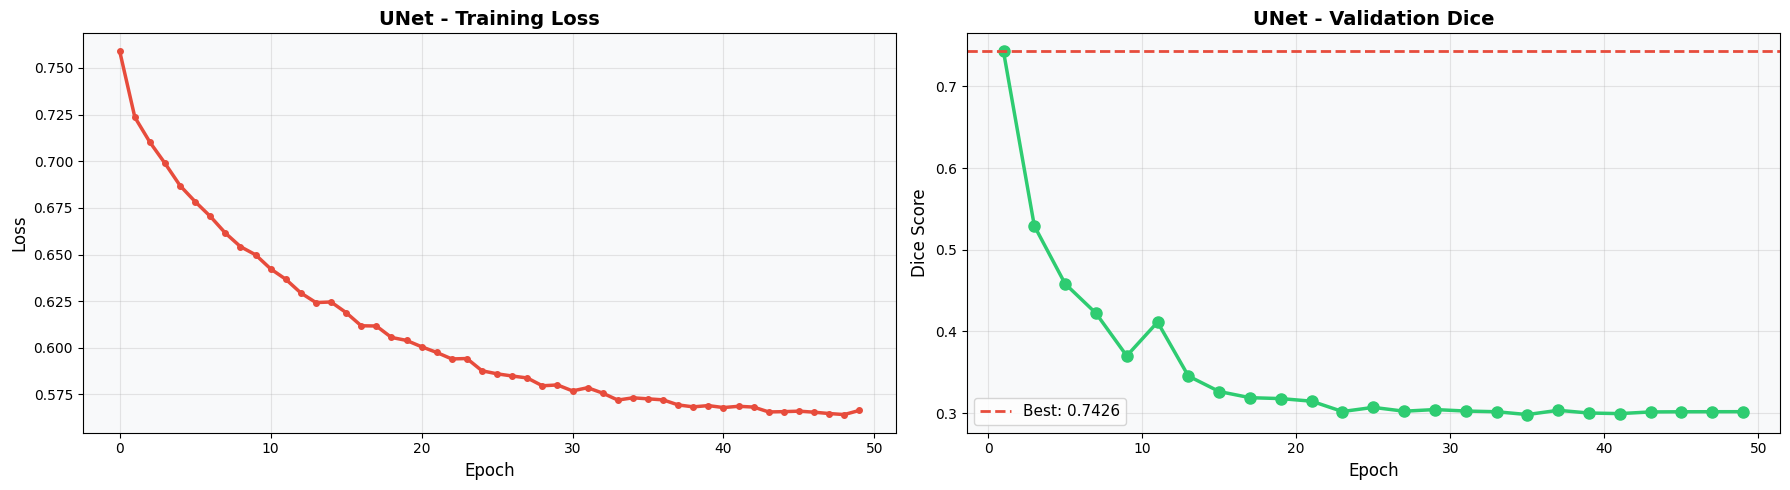

 Training curves saved as 'unet_training_curves.png'


In [16]:
print("Creating training visualizations...")

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
fig.patch.set_facecolor('white')

# Training Loss
axes[0].plot(epoch_losses, linewidth=2.5, color='#e74c3c', marker='o', markersize=4)
axes[0].set_title(f'{CONFIG["model_type"]} - Training Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_facecolor('#f8f9fa')

# Validation Dice
val_epochs = list(range(CONFIG['val_interval']-1, CONFIG['num_epochs'], CONFIG['val_interval']))
axes[1].plot(val_epochs, val_metrics, marker='o', linewidth=2.5, markersize=8, color='#2ecc71')
axes[1].axhline(y=best_metric, color='#e74c3c', linestyle='--', linewidth=2, label=f'Best: {best_metric:.4f}')
axes[1].set_title(f'{CONFIG["model_type"]} - Validation Dice', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Dice Score', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_facecolor('#f8f9fa')



plt.tight_layout()
plt.savefig(f'{CONFIG["model_type"].lower()}_training_curves.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f" Training curves saved as '{CONFIG['model_type'].lower()}_training_curves.png'")



 Running inference on test images...


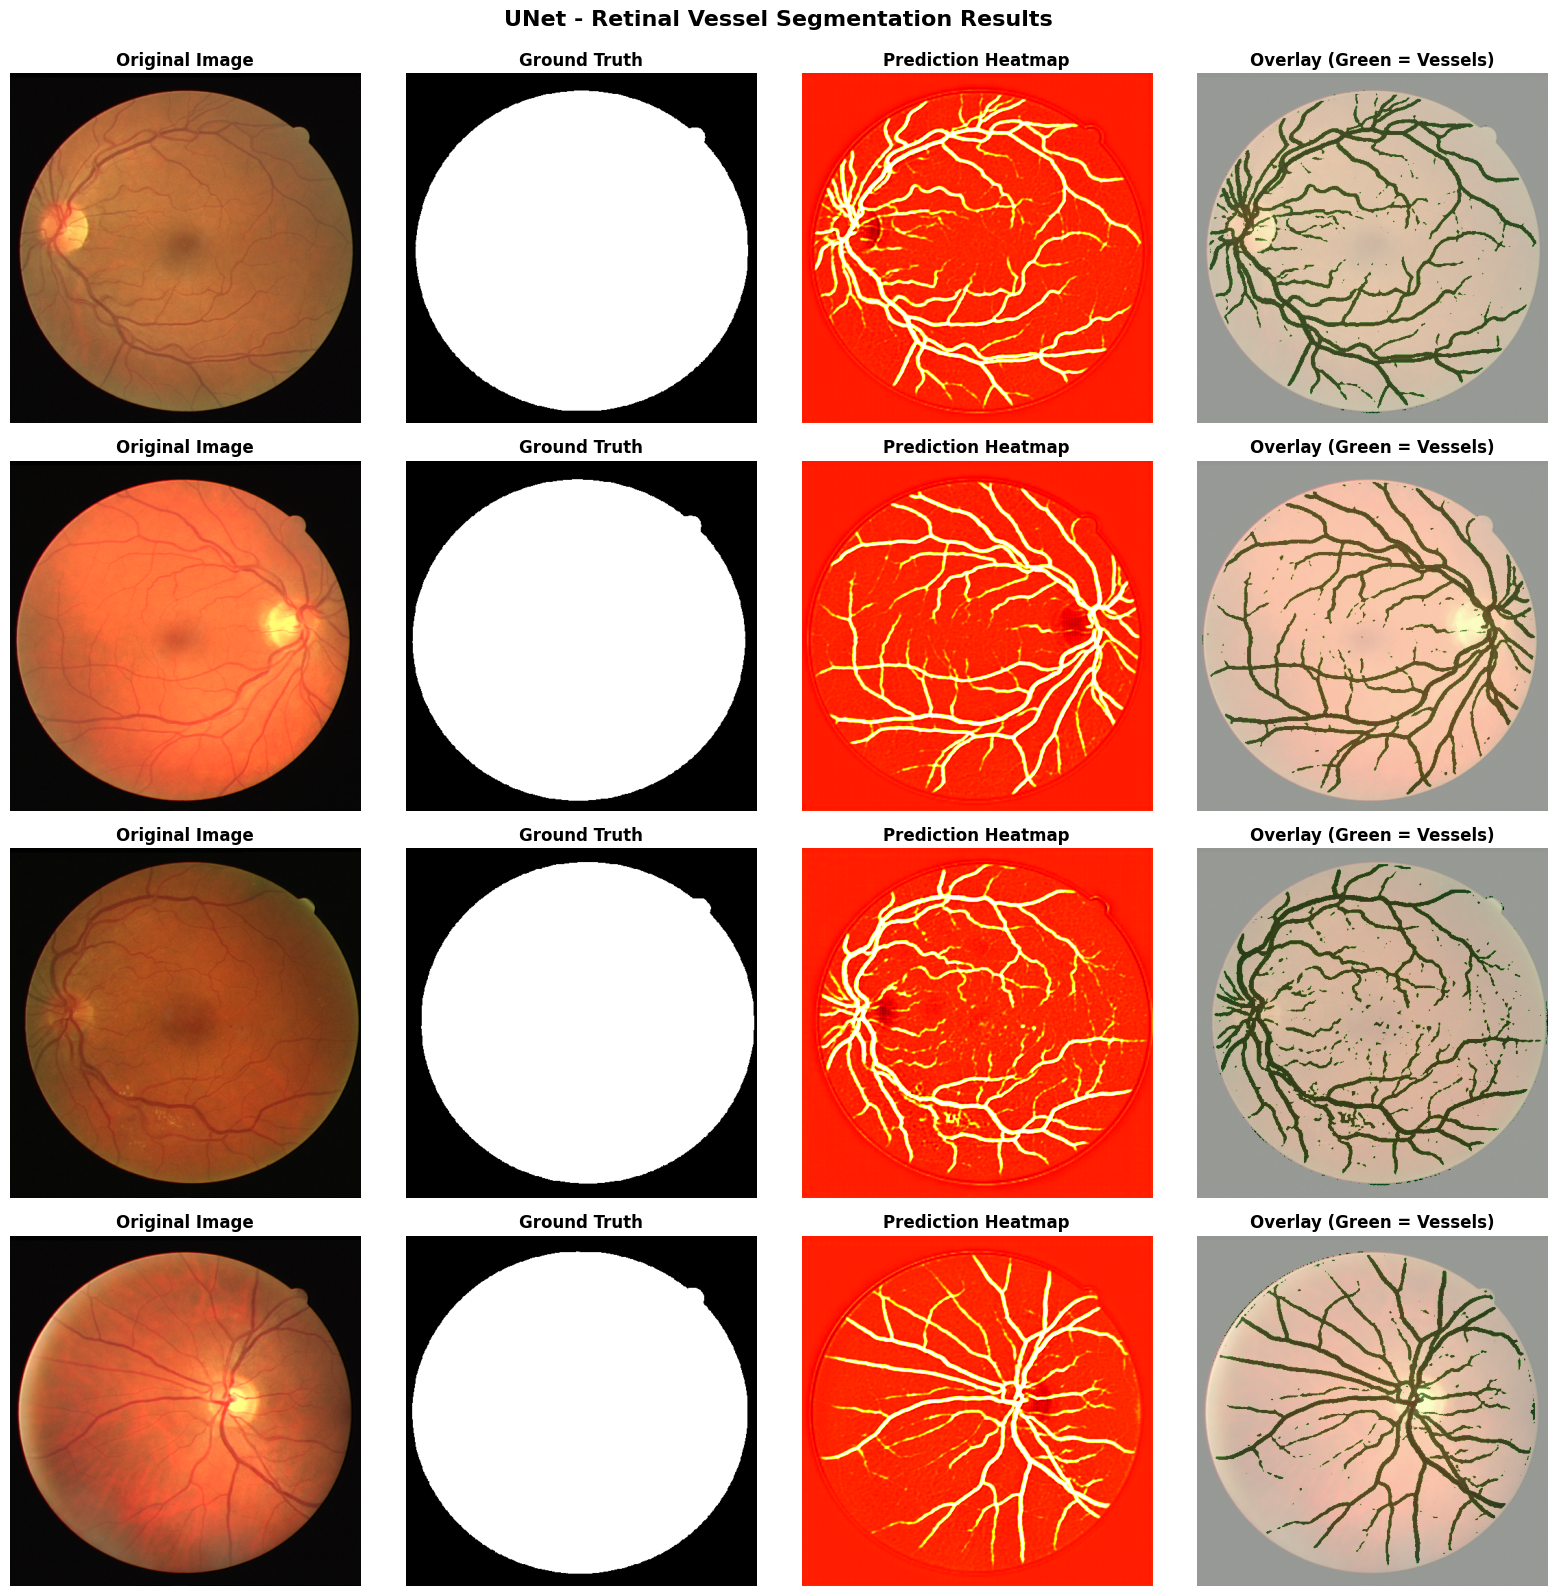

 Segmentation results saved as 'unet_segmentation_results.png'


In [17]:
print("\n Running inference on test images...")

model.eval()
num_samples = min(4, len(val_dataset))

fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples*4))
fig.patch.set_facecolor('white')

if num_samples == 1:
    axes = axes.reshape(1, -1)

with torch.no_grad():
    for idx in range(num_samples):
        # Get sample
        image, mask = val_dataset[idx]
        image_input = image.unsqueeze(0).to(device)
        
        # Predict
        output = model(image_input)
        pred = torch.sigmoid(output[0, 0]).cpu().numpy()
        
        # Convert to numpy for visualization
        img_np = image.permute(1, 2, 0).numpy()
        mask_np = mask[0].numpy()
        
        # Plot
        axes[idx, 0].imshow(img_np)
        axes[idx, 0].set_title('Original Image', fontsize=12, fontweight='bold')
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(mask_np, cmap='gray')
        axes[idx, 1].set_title('Ground Truth', fontsize=12, fontweight='bold')
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(pred, cmap='hot', vmin=0, vmax=1)
        axes[idx, 2].set_title('Prediction Heatmap', fontsize=12, fontweight='bold')
        axes[idx, 2].axis('off')
        
        # Overlay
        axes[idx, 3].imshow(img_np)
        pred_binary = (pred > 0.5).astype(float)
        axes[idx, 3].imshow(pred_binary, cmap='Greens', alpha=0.6)
        axes[idx, 3].set_title('Overlay (Green = Vessels)', fontsize=12, fontweight='bold')
        axes[idx, 3].axis('off')

plt.suptitle(f'{CONFIG["model_type"]} - Retinal Vessel Segmentation Results', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(f'{CONFIG["model_type"].lower()}_segmentation_results.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f" Segmentation results saved as '{CONFIG['model_type'].lower()}_segmentation_results.png'")


In [18]:
print("\n Computing detailed metrics on test set...")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for val_data in tqdm(val_loader, desc="Computing metrics"):
        val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)
        val_outputs = model(val_inputs)
        
        pred_probs = torch.sigmoid(val_outputs)
        pred_binary = (pred_probs > 0.5).float()
        
        # Dice per batch
        dice_metric(y_pred=pred_binary, y=val_labels)
        
        all_preds.append(pred_probs.cpu().numpy())
        all_labels.append(val_labels.cpu().numpy())

# Flatten all predictions
all_preds = np.concatenate(all_preds, axis=0).flatten()
all_labels = np.concatenate(all_labels, axis=0).flatten()

# Compute metrics
pred_binary_flat = (all_preds > 0.5).astype(int)

dice_final = dice_metric.aggregate().item()
precision = precision_score(all_labels, pred_binary_flat)
recall = recall_score(all_labels, pred_binary_flat)
f1 = f1_score(all_labels, pred_binary_flat)
auc_final = roc_auc_score(all_labels, all_preds)

# Precision-Recall curve
precision_curve, recall_curve, _ = precision_recall_curve(all_labels, all_preds)
pr_auc = auc(recall_curve, precision_curve)

# Specificity
tn = ((all_labels == 0) & (pred_binary_flat == 0)).sum()
fp = ((all_labels == 0) & (pred_binary_flat == 1)).sum()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\n" + "="*80)
print(f" {CONFIG['model_type']} - FINAL TEST METRICS")
print("="*80)
print(f"Dice Score:      {dice_final:.4f}  (Higher is better, max=1.0)")
print(f"Precision:       {precision:.4f}  (Positive predictive value)")
print(f"Recall/Sens.:    {recall:.4f}  (True positive rate)")
print(f"Specificity:     {specificity:.4f}  (True negative rate)")
print(f"F1-Score:        {f1:.4f}  (Harmonic mean of precision/recall)")
print(f"ROC-AUC:         {auc_final:.4f}  (Area under ROC curve)")
print(f"PR-AUC:          {pr_auc:.4f}  (Area under PR curve)")
print("="*80 + "\n")


 Computing detailed metrics on test set...


Computing metrics: 100%|██████████| 5/5 [00:00<00:00,  8.35it/s]



 UNet - FINAL TEST METRICS
Dice Score:      0.3018  (Higher is better, max=1.0)
Precision:       0.9979  (Positive predictive value)
Recall/Sens.:    0.1778  (True positive rate)
Specificity:     0.9992  (True negative rate)
F1-Score:        0.3018  (Harmonic mean of precision/recall)
ROC-AUC:         0.7588  (Area under ROC curve)
PR-AUC:          0.9025  (Area under PR curve)



📈 Creating ROC and Precision-Recall curves...


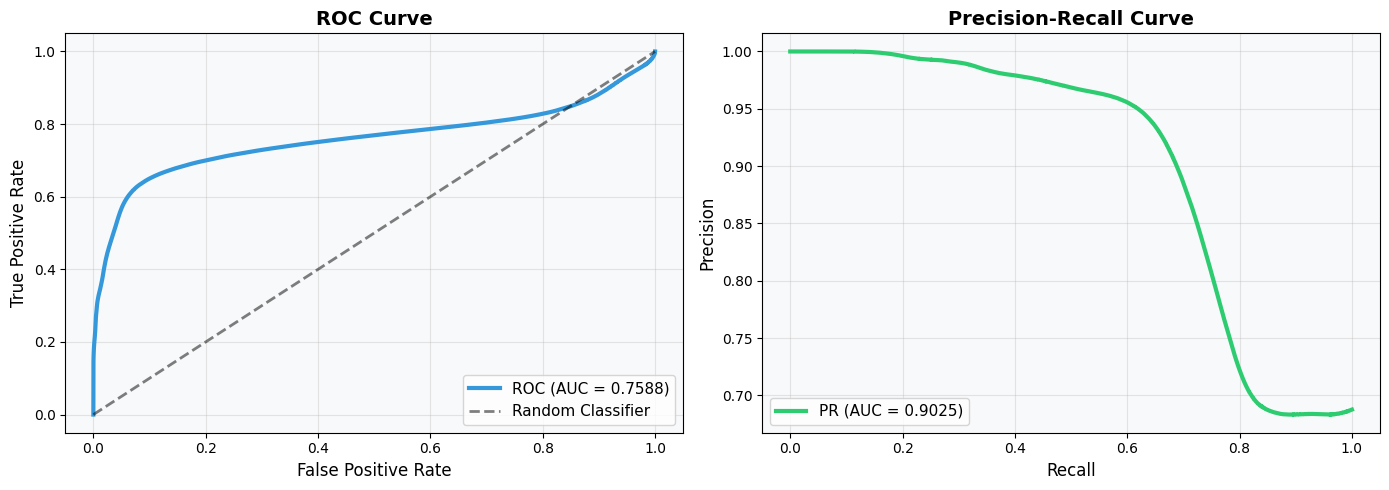

✅ ROC & PR curves saved as 'unet_roc_pr_curves.png'


In [19]:
print("📈 Creating ROC and Precision-Recall curves...")

fpr, tpr, _ = roc_curve(all_labels, all_preds)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('white')

# ROC Curve
axes[0].plot(fpr, tpr, linewidth=3, color='#3498db', label=f'ROC (AUC = {auc_final:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5, label='Random Classifier')
axes[0].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].legend(fontsize=11, loc='lower right')
axes[0].grid(True, alpha=0.3)
axes[0].set_facecolor('#f8f9fa')

# PR Curve
axes[1].plot(recall_curve, precision_curve, linewidth=3, color='#2ecc71', label=f'PR (AUC = {pr_auc:.4f})')
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].legend(fontsize=11, loc='lower left')
axes[1].grid(True, alpha=0.3)
axes[1].set_facecolor('#f8f9fa')

plt.tight_layout()
plt.savefig(f'{CONFIG["model_type"].lower()}_roc_pr_curves.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"✅ ROC & PR curves saved as '{CONFIG['model_type'].lower()}_roc_pr_curves.png'")


In [20]:
print("\n Saving final model...")

torch.save({
    'model_state_dict': model.state_dict(),
    'model_type': CONFIG['model_type'],
    'config': CONFIG,
    'metrics': {
        'dice': dice_final,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1': f1,
        'auc': auc_final,
        'pr_auc': pr_auc,
    },
    'epoch': CONFIG['num_epochs'],
}, f'{CONFIG["model_type"].lower()}_drive_final.pth')

print(f"✅ Model saved as '{CONFIG['model_type'].lower()}_drive_final.pth'")



 Saving final model...
✅ Model saved as 'unet_drive_final.pth'


In [21]:
print("\n" + "="*80)
print(" DRIVE RETINAL VESSEL SEGMENTATION COMPLETE!")
print("="*80)
print(f"\n Generated Files:")
print(f"   1. {CONFIG['model_type'].lower()}_drive_final.pth (Final model)")
print(f"   2. best_{CONFIG['model_type'].lower()}_drive.pth (Best checkpoint)")
print(f"   3. {CONFIG['model_type'].lower()}_training_curves.png")
print(f"   4. {CONFIG['model_type'].lower()}_segmentation_results.png")
print(f"   5. {CONFIG['model_type'].lower()}_roc_pr_curves.png")
print(f"\n Best Performance:")
print(f"   • Dice Score: {best_metric:.4f}")
print(f"   • ROC-AUC: {auc_final:.4f}")
print(f"   • Precision: {precision:.4f}")
print(f"   • Recall: {recall:.4f}")
print("\n" + "="*80)


 DRIVE RETINAL VESSEL SEGMENTATION COMPLETE!

 Generated Files:
   1. unet_drive_final.pth (Final model)
   2. best_unet_drive.pth (Best checkpoint)
   3. unet_training_curves.png
   4. unet_segmentation_results.png
   5. unet_roc_pr_curves.png

 Best Performance:
   • Dice Score: 0.7426
   • ROC-AUC: 0.7588
   • Precision: 0.9979
   • Recall: 0.1778



In [64]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path
import random
from tqdm import tqdm
import gc
import cv2
from sklearn.metrics import (roc_auc_score, precision_recall_curve, auc, 
                            roc_curve, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report)
import time
import json
from datetime import datetime


from monai.networks.nets import SegResNet
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric

print("="*80)
print(" ADVANCED SegResNet - DRIVE RETINAL VESSEL SEGMENTATION")
print("="*80)

 ADVANCED SegResNet - DRIVE RETINAL VESSEL SEGMENTATION


In [65]:
CONFIG = {
    'data_path': '/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE',
    'image_size': (512, 512),
    'batch_size': 4,
    'num_epochs': 150,
    'learning_rate': 1e-4,
    'val_interval': 2,
    'model_name': 'SegResNet_Deep',
    'save_dir': './outputs',
    
    # Advanced SegResNet Configuration
    'init_filters': 48,  # Increased from 32
    'blocks_down': [2, 3, 4, 4],  # Deeper blocks
    'blocks_up': [1, 1, 1],
    'dropout_prob': 0.15,
    
    # Training optimizations
    'use_amp': True,  # Mixed precision training
    'gradient_accumulation_steps': 2,
    'early_stopping_patience': 15,
    
    # Data augmentation
    'augmentation_prob': 0.8,
    'use_subset': False,

    'threshold': 0.15,
}

# Create output directory
os.makedirs(CONFIG['save_dir'], exist_ok=True)

print(f"\n Configuration:")
print(f"   Model: {CONFIG['model_name']}")
print(f"   Epochs: {CONFIG['num_epochs']}")
print(f"   Image Size: {CONFIG['image_size']}")
print(f"   Batch Size: {CONFIG['batch_size']}")
print(f"   Learning Rate: {CONFIG['learning_rate']}")
print(f"   Init Filters: {CONFIG['init_filters']}")
print(f"   Architecture: {CONFIG['blocks_down']} -> {CONFIG['blocks_up']}")



 Configuration:
   Model: SegResNet_Deep
   Epochs: 150
   Image Size: (512, 512)
   Batch Size: 4
   Learning Rate: 0.0001
   Init Filters: 48
   Architecture: [2, 3, 4, 4] -> [1, 1, 1]


In [47]:
class DRIVEDataset(Dataset):
    """Advanced DRIVE Dataset with Enhanced Preprocessing"""
    
    def __init__(self, data_path, split='train', image_size=(512, 512), 
                 augment=False, augment_prob=0.8, use_subset=False):
        self.data_path = Path(data_path)
        self.split = split
        self.image_size = image_size
        self.augment = augment
        self.augment_prob = augment_prob
        
        # Dataset paths
        if split == 'train':
            image_folder = self.data_path / 'training' / 'images'
            mask_folder = self.data_path / 'training' / '1st_manual'
            mask_suffix = '_manual1.gif'
        else:
            image_folder = self.data_path / 'test' / 'images'
            mask_folder = self.data_path / 'test' / 'mask'
            mask_suffix = '_test_mask.gif'
        
        # Match images and masks
        image_files = sorted(list(image_folder.glob('*.tif')))
        self.image_mask_pairs = []
        
        for img_path in image_files:
            img_id = img_path.stem.split('_')[0]
            mask_path = mask_folder / f"{img_id}{mask_suffix}"
            if mask_path.exists():
                self.image_mask_pairs.append((img_path, mask_path))
        
        if use_subset:
            self.image_mask_pairs = self.image_mask_pairs[:5]
        
        print(f"📊 {split.upper()} - Loaded {len(self.image_mask_pairs)} samples")
    
    def __len__(self):
        return len(self.image_mask_pairs)
    
    def clahe_enhancement(self, image):
        """Apply CLAHE enhancement to green channel"""
        lab = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        enhanced = cv2.merge([l, a, b])
        enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2RGB)
        return enhanced.astype(np.float32) / 255.0
    
    def __getitem__(self, idx):
        img_path, mask_path = self.image_mask_pairs[idx]
        
        # Load and resize
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        image = image.resize(self.image_size, Image.BILINEAR)
        mask = mask.resize(self.image_size, Image.NEAREST)
        
        # Convert to numpy
        image = np.array(image).astype(np.float32) / 255.0
        mask = np.array(mask).astype(np.float32) / 255.0
        mask = (mask > 0.5).astype(np.float32)
        
        # Get image dimensions
        h, w = image.shape[:2]
        
        # Apply CLAHE enhancement
        if self.split == 'train':
            image = self.clahe_enhancement(image)
        
        # Advanced augmentation
        if self.augment and random.random() < self.augment_prob:
            # Horizontal flip
            if random.random() > 0.5:
                image = np.flip(image, axis=1).copy()
                mask = np.flip(mask, axis=1).copy()
            
            # Vertical flip
            if random.random() > 0.5:
                image = np.flip(image, axis=0).copy()
                mask = np.flip(mask, axis=0).copy()
            
            # Rotation
            if random.random() > 0.5:
                angle = random.uniform(-45, 45)
                M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
                image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR)
                mask = cv2.warpAffine(mask, M, (w, h), flags=cv2.INTER_NEAREST)
            
            # Elastic deformation simulation with affine
            if random.random() > 0.7:
                pts1 = np.float32([[0, 0], [w-1, 0], [0, h-1], [w-1, h-1]])
                pts2 = pts1 + np.random.uniform(-20, 20, pts1.shape).astype(np.float32)
                M = cv2.getPerspectiveTransform(pts1, pts2)
                image = cv2.warpPerspective(image, M, (w, h))
                mask = cv2.warpPerspective(mask, M, (w, h))
            
            # Gaussian noise
            if random.random() > 0.7:
                noise = np.random.normal(0, 0.02, image.shape).astype(np.float32)
                image = np.clip(image + noise, 0, 1)
            
            # Brightness/Contrast
            if random.random() > 0.5:
                alpha = random.uniform(0.7, 1.3)
                beta = random.uniform(-0.2, 0.2)
                image = np.clip(alpha * image + beta, 0, 1)
            
            # Gamma correction
            if random.random() > 0.5:
                gamma = random.uniform(0.7, 1.3)
                image = np.power(image, gamma)
        
        # Convert to tensors
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        mask = torch.from_numpy(mask).unsqueeze(0).float()
        
        return image, mask


In [48]:
print("\n Loading datasets...")

train_dataset = DRIVEDataset(
    CONFIG['data_path'], 
    split='train', 
    image_size=CONFIG['image_size'],
    augment=True,
    augment_prob=CONFIG['augmentation_prob'],
    use_subset=CONFIG['use_subset']
)

val_dataset = DRIVEDataset(
    CONFIG['data_path'], 
    split='test', 
    image_size=CONFIG['image_size'],
    augment=False,
    use_subset=CONFIG['use_subset']
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f" Train: {len(train_dataset)} samples ({len(train_loader)} batches)")
print(f" Val: {len(val_dataset)} samples ({len(val_loader)} batches)")



 Loading datasets...
📊 TRAIN - Loaded 20 samples
📊 TEST - Loaded 20 samples
 Train: 20 samples (5 batches)
 Val: 20 samples (5 batches)


In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n Device: {device}")

print(f" Building Advanced SegResNet...")
model = SegResNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=1,
    init_filters=CONFIG['init_filters'],
    blocks_down=CONFIG['blocks_down'],
    blocks_up=CONFIG['blocks_up'],
    dropout_prob=CONFIG['dropout_prob'],
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: ~{total_params * 4 / 1024 / 1024:.2f} MB")



 Device: cuda
 Building Advanced SegResNet...
Total parameters: 15,703,777
Trainable parameters: 15,703,777
Model size: ~59.91 MB


In [50]:
loss_function = DiceCELoss(
    sigmoid=True,
    squared_pred=True,
    lambda_dice=0.6,  # Higher weight on Dice
    lambda_ce=0.4
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=1e-4,
    betas=(0.9, 0.999)
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,
    T_mult=2,
    eta_min=1e-6
)

dice_metric = DiceMetric(include_background=True, reduction='mean')
scaler = torch.cuda.amp.GradScaler(enabled=CONFIG['use_amp'])


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


In [52]:
print(f"\n{'='*80}")
print(f" STARTING TRAINING - {CONFIG['num_epochs']} EPOCHS")
print(f"{'='*80}\n")

# Tracking variables
best_metric = -1
best_epoch = -1
early_stop_counter = 0

history = {
    'train_loss': [],
    'val_loss': [],
    'val_dice': [],
    'val_auc': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': [],
    'learning_rate': []
}

start_time = time.time()

for epoch in range(CONFIG['num_epochs']):
    epoch_start = time.time()
    
    # ============================================================
    # TRAINING
    # ============================================================
    model.train()
    train_loss = 0
    train_steps = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['num_epochs']}")
    for batch_idx, (inputs, labels) in enumerate(pbar):
        inputs, labels = inputs.to(device), labels.to(device)
        
        with torch.amp.autocast('cuda', enabled=CONFIG['use_amp']):
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss = loss / CONFIG['gradient_accumulation_steps']
        
        scaler.scale(loss).backward()
        
        if (batch_idx + 1) % CONFIG['gradient_accumulation_steps'] == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        train_loss += loss.item() * CONFIG['gradient_accumulation_steps']
        train_steps += 1
        
        pbar.set_postfix({
            'loss': f'{loss.item() * CONFIG["gradient_accumulation_steps"]:.4f}',
            'lr': f'{optimizer.param_groups[0]["lr"]:.6f}'
        })
    
    train_loss /= train_steps
    history['train_loss'].append(train_loss)
    history['learning_rate'].append(optimizer.param_groups[0]['lr'])
    scheduler.step()
    
    epoch_time = time.time() - epoch_start
    
    # ============================================================
    # VALIDATION
    # ============================================================
    if (epoch + 1) % CONFIG['val_interval'] == 0:
        model.eval()
        val_loss = 0
        val_steps = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validating", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                
                with torch.amp.autocast('cuda', enabled=CONFIG['use_amp']):
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)
                
                val_loss += loss.item()
                val_steps += 1
                
                preds_sigmoid = torch.sigmoid(outputs)
                preds_binary = (preds_sigmoid > CONFIG['threshold']).float()
                dice_metric(y_pred=preds_binary, y=labels)
                
                all_preds.append(preds_sigmoid.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
        
        val_loss /= val_steps
        dice_score = dice_metric.aggregate().item()
        dice_metric.reset()
        
        # Compute detailed metrics
        all_preds = np.concatenate(all_preds).flatten()
        all_labels = np.concatenate(all_labels).flatten()
        pred_binary = (all_preds > CONFIG['threshold']).astype(int)
        
        auc_score = roc_auc_score(all_labels, all_preds)
        precision = precision_score(all_labels, pred_binary)
        recall = recall_score(all_labels, pred_binary)
        f1 = f1_score(all_labels, pred_binary)
        
        history['val_loss'].append(val_loss)
        history['val_dice'].append(dice_score)
        history['val_auc'].append(auc_score)
        history['val_precision'].append(precision)
        history['val_recall'].append(recall)
        history['val_f1'].append(f1)
        
        print(f"\n{'='*80}")
        print(f"Epoch {epoch+1}/{CONFIG['num_epochs']} - {epoch_time:.1f}s")
        print(f"{'='*80}")
        print(f" Train Loss: {train_loss:.4f}")
        print(f" Val Loss:   {val_loss:.4f}")
        print(f" Dice:       {dice_score:.4f}")
        print(f" AUC:        {auc_score:.4f}")
        print(f" Precision:  {precision:.4f}")
        print(f" Recall:     {recall:.4f}")
        print(f" F1:         {f1:.4f}")
        print(f"  LR:         {optimizer.param_groups[0]['lr']:.6f}")
        
        # Save best model
        if dice_score > best_metric:
            best_metric = dice_score
            best_epoch = epoch + 1
            early_stop_counter = 0
            
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_dice': best_metric,
                'auc': auc_score,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'config': CONFIG,
                'history': history
            }
            
            torch.save(checkpoint, f"{CONFIG['save_dir']}/best_segresnet_model.pth")
            print(f" NEW BEST MODEL! Dice: {best_metric:.4f}")
        else:
            early_stop_counter += 1
            if early_stop_counter >= CONFIG['early_stopping_patience']:
                print(f"\n Early stopping triggered after {CONFIG['early_stopping_patience']} epochs without improvement")
                break
        
        print(f"{'='*80}\n")
    
    gc.collect()
    torch.cuda.empty_cache()

total_time = time.time() - start_time

print(f"\n{'='*80}")
print(f" TRAINING COMPLETE!")
print(f"{'='*80}")
print(f" Best Dice Score: {best_metric:.4f} at epoch {best_epoch}")
print(f"  Total Time: {total_time/60:.1f} minutes")
print(f"{'='*80}\n")



 STARTING TRAINING - 150 EPOCHS



Epoch 2/150: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s, loss=0.5029, lr=0.000051]



Epoch 2/150 - 3.5s
 Train Loss: 0.5113
 Val Loss:   0.6787
 Dice:       0.9738
 AUC:        0.9964
 Precision:  0.9883
 Recall:     0.9598
 F1:         0.9738
  LR:         0.000035
 NEW BEST MODEL! Dice: 0.9738



Epoch 4/150: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s, loss=0.4960, lr=0.000021]



Epoch 4/150 - 3.5s
 Train Loss: 0.5048
 Val Loss:   0.6820
 Dice:       0.9763
 AUC:        0.9970
 Precision:  0.9940
 Recall:     0.9593
 F1:         0.9763
  LR:         0.000010
 NEW BEST MODEL! Dice: 0.9763



Epoch 6/150: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s, loss=0.4993, lr=0.000003]



Epoch 6/150 - 3.5s
 Train Loss: 0.4998
 Val Loss:   0.6930
 Dice:       0.9753
 AUC:        0.9970
 Precision:  0.9938
 Recall:     0.9576
 F1:         0.9754
  LR:         0.000100



Epoch 8/150: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s, loss=0.4697, lr=0.000099]



Epoch 8/150 - 3.5s
 Train Loss: 0.4820
 Val Loss:   0.7526
 Dice:       0.9653
 AUC:        0.9928
 Precision:  0.9815
 Recall:     0.9498
 F1:         0.9654
  LR:         0.000098



Epoch 10/150: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s, loss=0.4244, lr=0.000095]



Epoch 10/150 - 3.6s
 Train Loss: 0.4352
 Val Loss:   0.8313
 Dice:       0.8944
 AUC:        0.8924
 Precision:  0.9374
 Recall:     0.8559
 F1:         0.8948
  LR:         0.000091



Epoch 12/150: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s, loss=0.3801, lr=0.000086]



Epoch 12/150 - 3.5s
 Train Loss: 0.4041
 Val Loss:   0.9179
 Dice:       0.7119
 AUC:        0.7987
 Precision:  0.9003
 Recall:     0.5895
 F1:         0.7125
  LR:         0.000080



Epoch 14/150: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s, loss=0.4039, lr=0.000073]



Epoch 14/150 - 3.5s
 Train Loss: 0.3675
 Val Loss:   0.9126
 Dice:       0.6186
 AUC:        0.8042
 Precision:  0.9011
 Recall:     0.4713
 F1:         0.6189
  LR:         0.000066



Epoch 16/150: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s, loss=0.3213, lr=0.000058]



Epoch 16/150 - 3.5s
 Train Loss: 0.3415
 Val Loss:   0.9018
 Dice:       0.6272
 AUC:        0.8867
 Precision:  0.9246
 Recall:     0.4750
 F1:         0.6276
  LR:         0.000051



Epoch 18/150: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s, loss=0.3352, lr=0.000043]



Epoch 18/150 - 3.5s
 Train Loss: 0.3299
 Val Loss:   0.8709
 Dice:       0.6534
 AUC:        0.8737
 Precision:  0.9331
 Recall:     0.5029
 F1:         0.6536
  LR:         0.000035



Epoch 20/150: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s, loss=0.3107, lr=0.000028]



Epoch 20/150 - 3.5s
 Train Loss: 0.3242
 Val Loss:   0.9497
 Dice:       0.4930
 AUC:        0.8120
 Precision:  0.9057
 Recall:     0.3391
 F1:         0.4935
  LR:         0.000021



Epoch 22/150: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s, loss=0.2834, lr=0.000015]



Epoch 22/150 - 3.5s
 Train Loss: 0.3064
 Val Loss:   0.9047
 Dice:       0.5844
 AUC:        0.8898
 Precision:  0.9421
 Recall:     0.4238
 F1:         0.5847
  LR:         0.000010



Epoch 24/150: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s, loss=0.3070, lr=0.000006]



Epoch 24/150 - 3.5s
 Train Loss: 0.3072
 Val Loss:   0.9592
 Dice:       0.4568
 AUC:        0.7537
 Precision:  0.9021
 Recall:     0.3062
 F1:         0.4572
  LR:         0.000003



Epoch 26/150: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s, loss=0.3069, lr=0.000002]



Epoch 26/150 - 3.5s
 Train Loss: 0.3039
 Val Loss:   0.9510
 Dice:       0.4712
 AUC:        0.7650
 Precision:  0.9075
 Recall:     0.3186
 F1:         0.4716
  LR:         0.000100



Epoch 28/150: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s, loss=0.3890, lr=0.000100]



Epoch 28/150 - 3.5s
 Train Loss: 0.4690
 Val Loss:   0.7849
 Dice:       0.8501
 AUC:        0.8966
 Precision:  0.9518
 Recall:     0.7683
 F1:         0.8502
  LR:         0.000099



Epoch 30/150: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s, loss=0.2992, lr=0.000099]



Epoch 30/150 - 3.6s
 Train Loss: 0.3319
 Val Loss:   0.8872
 Dice:       0.7917
 AUC:        0.9629
 Precision:  0.9760
 Recall:     0.6667
 F1:         0.7922
  LR:         0.000098



Epoch 32/150: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s, loss=0.2628, lr=0.000096]



Epoch 32/150 - 3.5s
 Train Loss: 0.2852
 Val Loss:   1.0025
 Dice:       0.3400
 AUC:        0.2467
 Precision:  0.8057
 Recall:     0.2157
 F1:         0.3403
  LR:         0.000095



Epoch 34/150: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s, loss=0.2542, lr=0.000093]



Epoch 34/150 - 3.5s
 Train Loss: 0.2734
 Val Loss:   0.8992
 Dice:       0.5253
 AUC:        0.9374
 Precision:  0.9676
 Recall:     0.3608
 F1:         0.5256
  LR:         0.000091

 Early stopping triggered after 15 epochs without improvement

 TRAINING COMPLETE!
 Best Dice Score: 0.9763 at epoch 4
  Total Time: 5.4 minutes



In [53]:
with open(f"{CONFIG['save_dir']}/training_history.json", 'w') as f:
    json.dump(history, f, indent=4)


 Creating advanced visualizations...


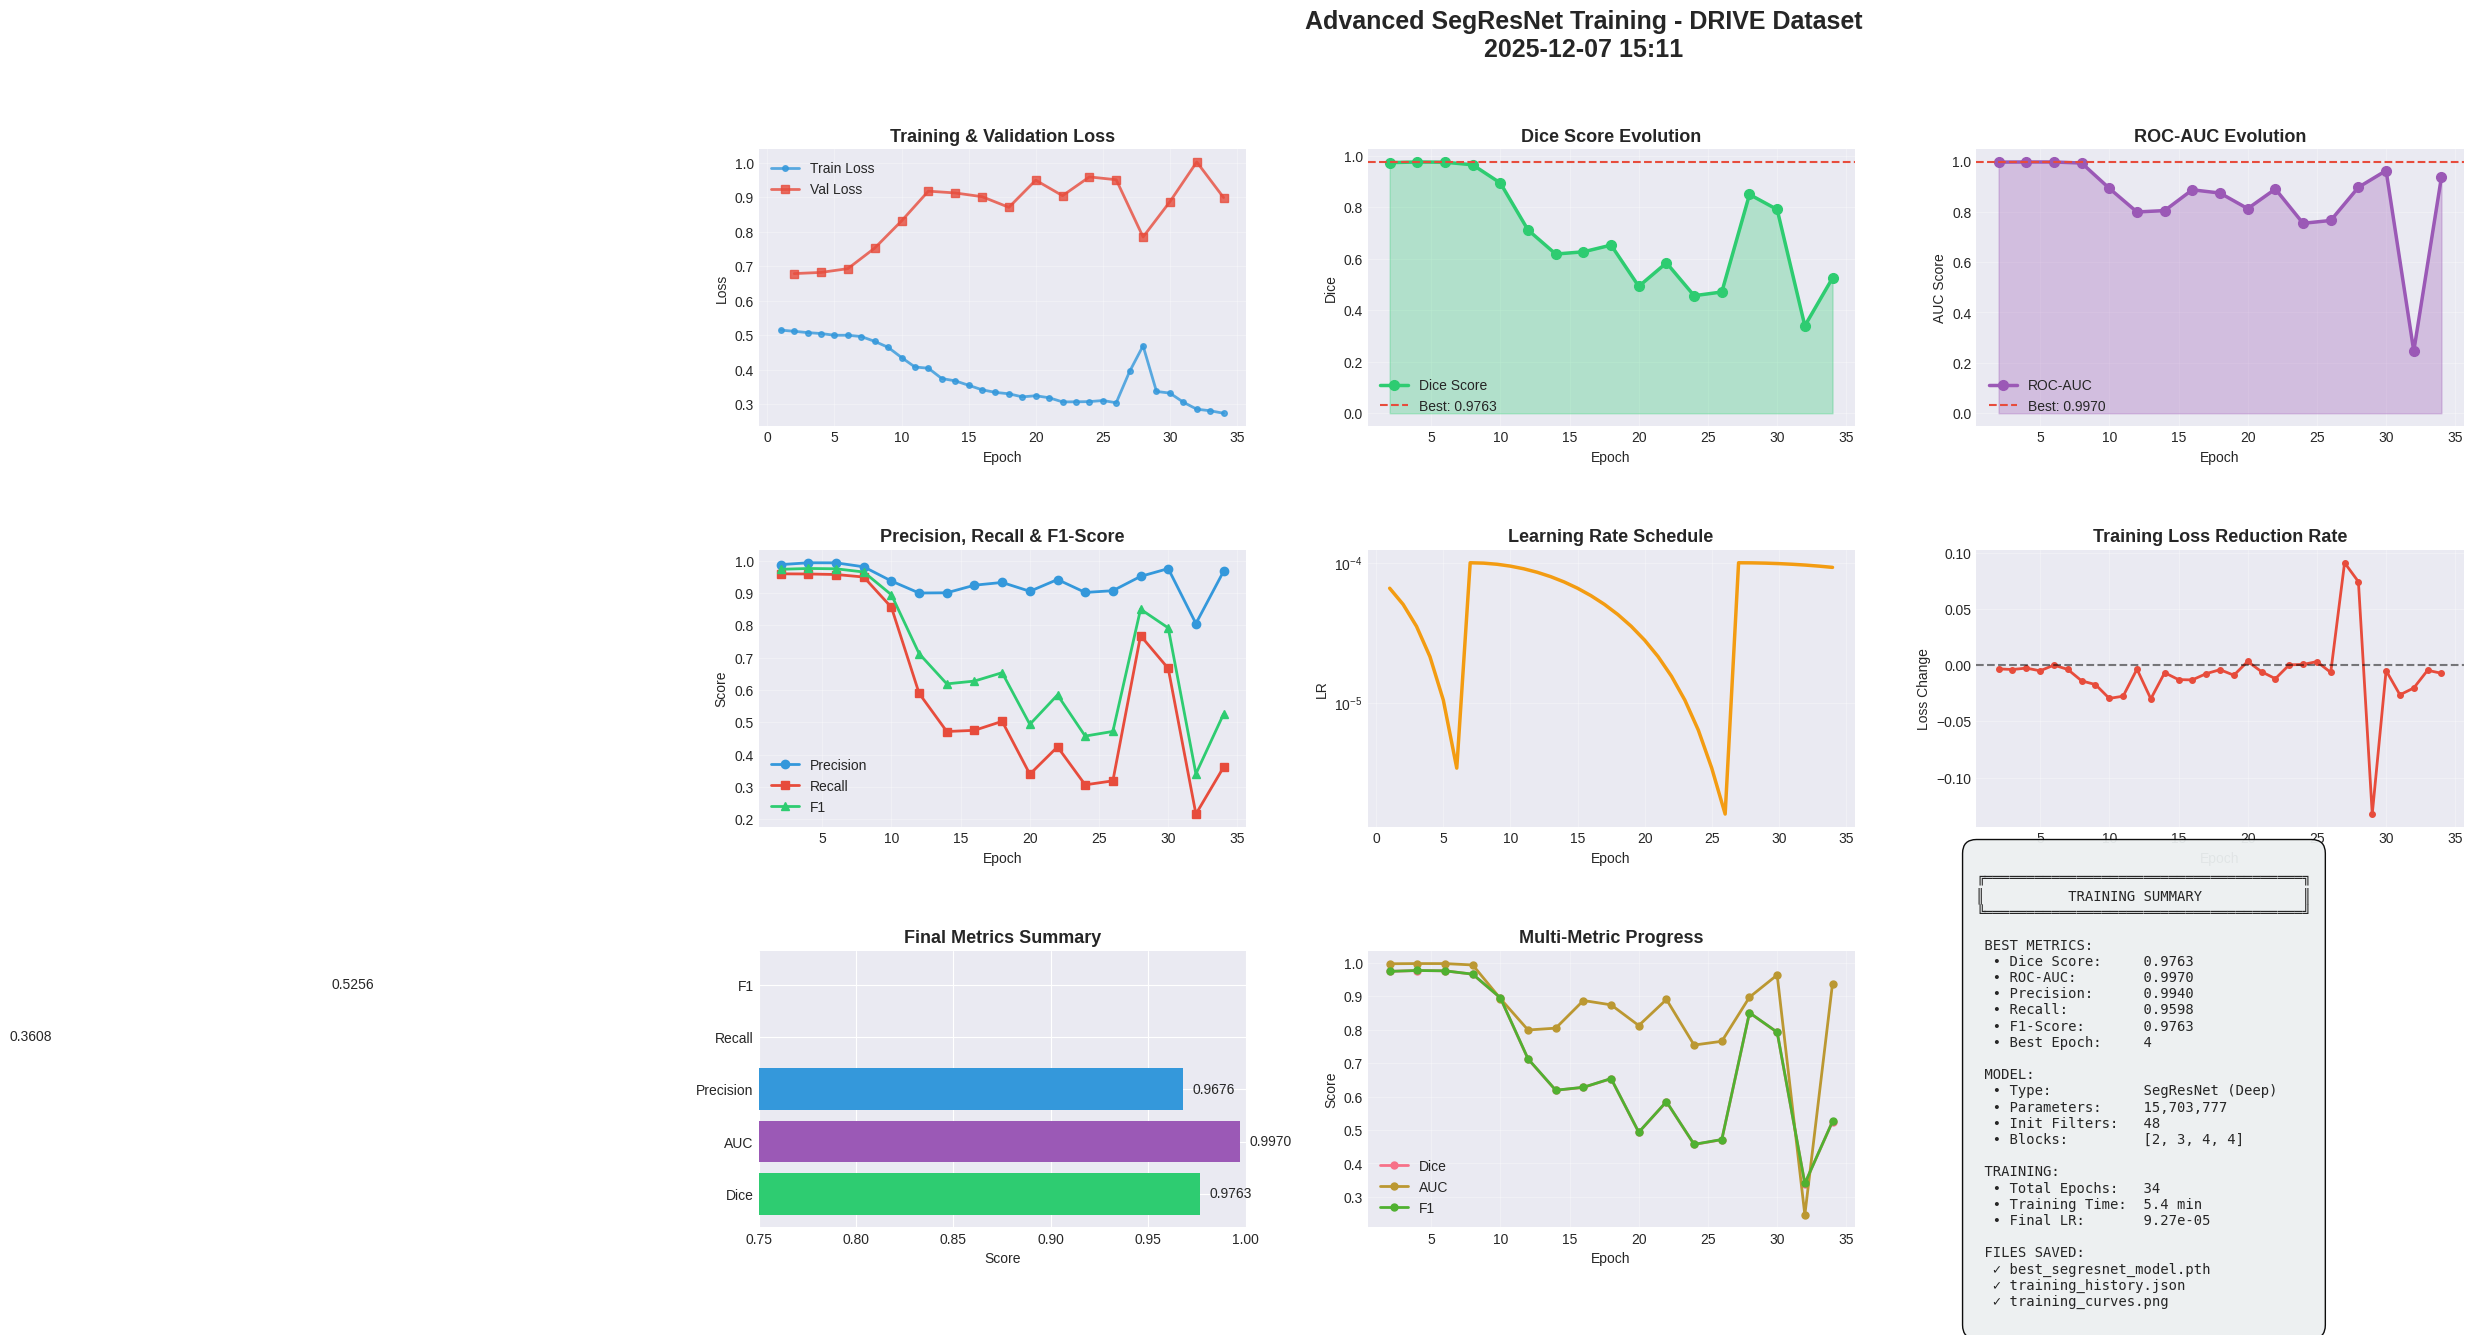

 Saved: training_curves_advanced.png


In [59]:
print(" Creating advanced visualizations...")

import matplotlib.gridspec as gridspec

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# -----------------------------
# Create Figure + GridSpec
# -----------------------------
fig = plt.figure(figsize=(22, 14))
fig.patch.set_facecolor('white')

# Grid: 3 rows × 3 columns
# Summary box (ax9) will fill entire bottom-right cell
gs = gridspec.GridSpec(
    3, 3, figure=fig,
    wspace=0.25,
    hspace=0.45
)

# -----------------------------
# Define subplot positions
# -----------------------------
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])

ax7 = fig.add_subplot(gs[2, 0])
ax8 = fig.add_subplot(gs[2, 1])
ax9 = fig.add_subplot(gs[2, 2])   # Summary box (right side)

# -----------------------------------------------------
# 1. Training & Validation Loss
# -----------------------------------------------------
epochs_range = range(1, len(history['train_loss']) + 1)
val_epochs = list(range(CONFIG['val_interval'],
                        CONFIG['val_interval'] * len(history['val_loss']) + 1,
                        CONFIG['val_interval']))

ax1.plot(epochs_range, history['train_loss'], 'o-', linewidth=2, markersize=4,
         color='#3498db', label='Train Loss', alpha=0.8)
ax1.plot(val_epochs, history['val_loss'], 's-', linewidth=2, markersize=6,
         color='#e74c3c', label='Val Loss', alpha=0.8)
ax1.set_title("Training & Validation Loss", fontsize=13, fontweight='bold')
ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss")
ax1.legend(); ax1.grid(True, alpha=0.3)

# -----------------------------------------------------
# 2. Dice Score Evolution
# -----------------------------------------------------
ax2.plot(val_epochs, history['val_dice'], 'o-', linewidth=2.5, markersize=7,
         color='#2ecc71', label='Dice Score')
ax2.axhline(best_metric, linestyle='--', color='#e74c3c',
            label=f"Best: {best_metric:.4f}")
ax2.fill_between(val_epochs, history['val_dice'], color='#2ecc71', alpha=0.3)
ax2.set_title("Dice Score Evolution", fontsize=13, fontweight='bold')
ax2.set_xlabel("Epoch"); ax2.set_ylabel("Dice")
ax2.legend(); ax2.grid(True, alpha=0.3)

# -----------------------------------------------------
# 3. ROC-AUC Evolution
# -----------------------------------------------------
ax3.plot(val_epochs, history['val_auc'], 'o-', linewidth=2.5, markersize=7,
         color='#9b59b6', label='ROC-AUC')
ax3.axhline(max(history['val_auc']), linestyle='--', color='#e74c3c',
            label=f"Best: {max(history['val_auc']):.4f}")
ax3.fill_between(val_epochs, history['val_auc'], alpha=0.3, color='#9b59b6')
ax3.set_title("ROC-AUC Evolution", fontsize=13, fontweight='bold')
ax3.set_xlabel("Epoch"); ax3.set_ylabel("AUC Score")
ax3.legend(); ax3.grid(True, alpha=0.3)

# -----------------------------------------------------
# 4. Precision, Recall, F1
# -----------------------------------------------------
ax4.plot(val_epochs, history['val_precision'], 'o-', label="Precision",
         linewidth=2, markersize=6, color='#3498db')
ax4.plot(val_epochs, history['val_recall'], 's-', label="Recall",
         linewidth=2, markersize=6, color='#e74c3c')
ax4.plot(val_epochs, history['val_f1'], '^-', label="F1",
         linewidth=2, markersize=6, color='#2ecc71')
ax4.set_title("Precision, Recall & F1-Score", fontsize=13, fontweight='bold')
ax4.set_xlabel("Epoch"); ax4.set_ylabel("Score")
ax4.legend(); ax4.grid(True, alpha=0.3)

# -----------------------------------------------------
# 5. Learning Rate Schedule
# -----------------------------------------------------
ax5.plot(epochs_range, history['learning_rate'], color='#f39c12', linewidth=2.5)
ax5.set_title("Learning Rate Schedule", fontsize=13, fontweight='bold')
ax5.set_xlabel("Epoch"); ax5.set_ylabel("LR")
ax5.set_yscale("log")
ax5.grid(True, alpha=0.3)

# -----------------------------------------------------
# 6. Loss Reduction Rate
# -----------------------------------------------------
if len(history['train_loss']) > 1:
    loss_reduction = np.diff(history['train_loss'])
    ax6.plot(range(2, len(history['train_loss']) + 1), loss_reduction,
             linewidth=2, color='#e74c3c', marker='o', markersize=4)
    ax6.axhline(0, linestyle='--', color='black', alpha=0.5)
ax6.set_title("Training Loss Reduction Rate", fontsize=13, fontweight='bold')
ax6.set_xlabel("Epoch"); ax6.set_ylabel("Loss Change")
ax6.grid(True, alpha=0.3)

# -----------------------------------------------------
# 7. Final Metrics (Bar Chart)
# -----------------------------------------------------
metrics_names = ["Dice", "AUC", "Precision", "Recall", "F1"]
metrics_values = [
    best_metric,
    max(history['val_auc']),
    history['val_precision'][-1],
    history['val_recall'][-1],
    history['val_f1'][-1]
]

ax7.barh(metrics_names, metrics_values,
         color=["#2ecc71", "#9b59b6", "#3498db", "#e74c3c", "#f39c12"])
ax7.set_title("Final Metrics Summary", fontsize=13, fontweight='bold')
ax7.set_xlabel("Score"); ax7.set_xlim([0.75, 1.0])
for i, v in enumerate(metrics_values):
    ax7.text(v + 0.005, i, f"{v:.4f}", fontsize=10, va='center')

# -----------------------------------------------------
# 8. Multi-Metric Progress
# -----------------------------------------------------
progress_data = {
    "Dice": history['val_dice'],
    "AUC": history['val_auc'],
    "F1": history['val_f1']
}
for name, values in progress_data.items():
    ax8.plot(val_epochs, values, 'o-', linewidth=2, markersize=5, label=name)

ax8.set_title("Multi-Metric Progress", fontsize=13, fontweight='bold')
ax8.set_xlabel("Epoch"); ax8.set_ylabel("Score")
ax8.legend(); ax8.grid(True, alpha=0.3)

# -----------------------------------------------------
# 9. Summary Box (Right Side Bottom)
# -----------------------------------------------------
ax9.axis("off")
summary_text = f"""
╔══════════════════════════════════════╗
║          TRAINING SUMMARY            ║
╚══════════════════════════════════════╝

 BEST METRICS:
  • Dice Score:     {best_metric:.4f}
  • ROC-AUC:        {max(history['val_auc']):.4f}
  • Precision:      {max(history['val_precision']):.4f}
  • Recall:         {max(history['val_recall']):.4f}
  • F1-Score:       {max(history['val_f1']):.4f}
  • Best Epoch:     {best_epoch}

 MODEL:
  • Type:           SegResNet (Deep)
  • Parameters:     {total_params:,}
  • Init Filters:   {CONFIG['init_filters']}
  • Blocks:         {CONFIG['blocks_down']}

 TRAINING:
  • Total Epochs:   {epoch + 1}
  • Training Time:  {total_time/60:.1f} min
  • Final LR:       {history['learning_rate'][-1]:.2e}

 FILES SAVED:
  ✓ best_segresnet_model.pth
  ✓ training_history.json
  ✓ training_curves.png
"""
ax9.text(0, 0.5, summary_text,
         fontsize=10, family="monospace", va="center",
         bbox=dict(boxstyle="round,pad=1.0",
                   facecolor="#ecf0f1", alpha=0.95))

# -----------------------------------------------------
# Title + Save
# -----------------------------------------------------
plt.suptitle(
    f"Advanced SegResNet Training - DRIVE Dataset\n{datetime.now().strftime('%Y-%m-%d %H:%M')}",
    fontsize=18, fontweight='bold'
)

plt.savefig(f"{CONFIG['save_dir']}/training_curves_advanced.png",
            dpi=300, bbox_inches='tight')
plt.show()

print(" Saved: training_curves_advanced.png")


In [ ]:
print("\n Running final evaluation and creating visualizations...")

# Load best model
checkpoint = torch.load(f"{CONFIG['save_dir']}/best_segresnet_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Detailed evaluation
print("\n Computing comprehensive test metrics...")

all_preds = []
all_labels = []
all_images = []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Final Evaluation"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs)
        
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        all_images.append(inputs.cpu().numpy())

all_preds = np.concatenate(all_preds).flatten()
all_labels = np.concatenate(all_labels).flatten()

# Compute final metrics
pred_binary = (all_preds > 0.5).astype(int)
cm = confusion_matrix(all_labels, pred_binary)

tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
dice_final = 2 * tp / (2 * tp + fp + fn)
iou = tp / (tp + fp + fn)

# ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

# Precision-Recall curve
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(all_labels, all_preds)
pr_auc = auc(recall_curve, precision_curve)

print("\n" + "="*80)
print(" FINAL TEST METRICS")
print("="*80)
print(f"Dice Score:      {dice_final:.4f}")
print(f"IoU (Jaccard):   {iou:.4f}")
print(f"Accuracy:        {accuracy:.4f}")
print(f"Sensitivity:     {sensitivity:.4f}")
print(f"Specificity:     {specificity:.4f}")
print(f"Precision:       {precision_score(all_labels, pred_binary):.4f}")
print(f"Recall:          {recall_score(all_labels, pred_binary):.4f}")
print(f"F1-Score:        {f1_score(all_labels, pred_binary):.4f}")
print(f"ROC-AUC:         {roc_auc:.4f}")
print(f"PR-AUC:          {pr_auc:.4f}")
print("="*80)

# 2. ADVANCED METRICS VISUALIZATION
fig = plt.figure(figsize=(20, 10))
fig.patch.set_facecolor('white')

# ROC Curve
ax1 = plt.subplot(2, 4, 1)
ax1.plot(fpr, tpr, linewidth=3, color='#3498db', label=f'ROC (AUC = {roc_auc:.4f})')
ax1.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5)
ax1.fill_between(fpr, tpr, alpha=0.3, color='#3498db')
ax1.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
ax1.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
ax1.set_title('ROC Curve', fontsize=13, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, alpha=0.3)

# Precision-Recall Curve
ax2 = plt.subplot(2, 4, 2)
ax2.plot(recall_curve, precision_curve, linewidth=3, color='#2ecc71', 
         label=f'PR (AUC = {pr_auc:.4f})')
ax2.fill_between(recall_curve, precision_curve, alpha=0.3, color='#2ecc71')
ax2.set_xlabel('Recall', fontsize=11, fontweight='bold')
ax2.set_ylabel('Precision', fontsize=11, fontweight='bold')
ax2.set_title('Precision-Recall Curve', fontsize=13, fontweight='bold')
ax2.legend(loc='lower left', fontsize=10)
ax2.grid(True, alpha=0.3)

# Confusion Matrix
ax3 = plt.subplot(2, 4, 3)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', 
            xticklabels=['Background', 'Vessel'],
            yticklabels=['Background', 'Vessel'],
            cbar_kws={'label': 'Normalized Count'}, ax=ax3)
ax3.set_ylabel('True Label', fontsize=11, fontweight='bold')
ax3.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
ax3.set_title('Normalized Confusion Matrix', fontsize=13, fontweight='bold')

# Threshold Analysis
ax4 = plt.subplot(2, 4, 4)
# Find optimal threshold
f1_scores = 2 * precision_curve * recall_curve / (precision_curve + recall_curve + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = pr_thresholds[optimal_idx] if optimal_idx < len(pr_thresholds) else 0.5
ax4.plot(pr_thresholds, precision_curve[:-1], 'b-', linewidth=2, label='Precision')
ax4.plot(pr_thresholds, recall_curve[:-1], 'r-', linewidth=2, label='Recall')
ax4.plot(pr_thresholds, f1_scores[:-1], 'g-', linewidth=2, label='F1-Score')
ax4.axvline(x=optimal_threshold, color='black', linestyle='--', linewidth=2, 
            label=f'Optimal: {optimal_threshold:.3f}')
ax4.set_xlabel('Threshold', fontsize=11, fontweight='bold')
ax4.set_ylabel('Score', fontsize=11, fontweight='bold')
ax4.set_title('Threshold Analysis', fontsize=13, fontweight='bold')
ax4.legend(loc='best', fontsize=9)
ax4.grid(True, alpha=0.3)

# Metrics Radar Chart
ax5 = plt.subplot(2, 4, 5, projection='polar')
metrics_radar = ['Dice', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision']
values_radar = [dice_final, accuracy, sensitivity, specificity, 
                precision_score(all_labels, pred_binary)]
angles = np.linspace(0, 2 * np.pi, len(metrics_radar), endpoint=False).tolist()
values_radar += values_radar[:1]
angles += angles[:1]
ax5.plot(angles, values_radar, 'o-', linewidth=2, color='#e74c3c')
ax5.fill(angles, values_radar, alpha=0.25, color='#e74c3c')
ax5.set_xticks(angles[:-1])
ax5.set_xticklabels(metrics_radar, fontsize=9)
ax5.set_ylim(0, 1)
ax5.set_title('Metrics Radar', fontsize=13, fontweight='bold', pad=20)
ax5.grid(True)

# Performance Summary
ax6 = plt.subplot(2, 4, 6)
ax6.axis('off')
performance_text = f"""
╔════════════════════════════════╗
║   PERFORMANCE METRICS          ║
╚════════════════════════════════╝

SEGMENTATION QUALITY:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Dice Score:      {dice_final:.4f}
  IoU (Jaccard):   {iou:.4f}
  
CLASSIFICATION METRICS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Accuracy:        {accuracy:.4f}
  Precision:       {precision_score(all_labels, pred_binary):.4f}
  Recall:          {recall_score(all_labels, pred_binary):.4f}
  F1-Score:        {f1_score(all_labels, pred_binary):.4f}
  
SENSITIVITY ANALYSIS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Sensitivity:     {sensitivity:.4f}
  Specificity:     {specificity:.4f}
  
AREA UNDER CURVES:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  ROC-AUC:         {roc_auc:.4f}
  PR-AUC:          {pr_auc:.4f}
  
CONFUSION MATRIX:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  True Neg:        {tn:,}
  False Pos:       {fp:,}
  False Neg:       {fn:,}
  True Pos:        {tp:,}

OPTIMAL THRESHOLD: {optimal_threshold:.3f}
"""
ax6.text(0.05, 0.5, performance_text, fontsize=9, family='monospace',
        verticalalignment='center',
        bbox=dict(boxstyle='round', facecolor='#e8f8f5', alpha=0.9))

# Prediction Distribution
ax7 = plt.subplot(2, 4, 7)
ax7.hist(all_preds[all_labels == 0], bins=50, alpha=0.6, color='blue', 
         label='Background', density=True)
ax7.hist(all_preds[all_labels == 1], bins=50, alpha=0.6, color='red', 
         label='Vessel', density=True)
ax7.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
ax7.set_xlabel('Prediction Probability', fontsize=11, fontweight='bold')
ax7.set_ylabel('Density', fontsize=11, fontweight='bold')
ax7.set_title('Prediction Distribution', fontsize=13, fontweight='bold')
ax7.legend(fontsize=9)
ax7.grid(True, alpha=0.3)

# Model Performance Summary
ax8 = plt.subplot(2, 4, 8)
metrics_names = ['Dice', 'IoU', 'Accuracy', 'F1', 'AUC']
metrics_vals = [dice_final, iou, accuracy, f1_score(all_labels, pred_binary), roc_auc]
colors = ['#2ecc71', '#3498db', '#9b59b6', '#f39c12', '#e74c3c']
bars = ax8.bar(metrics_names, metrics_vals, color=colors, edgecolor='black', linewidth=2)
ax8.set_ylabel('Score', fontsize=11, fontweight='bold')
ax8.set_title('Final Performance Summary', fontsize=13, fontweight='bold')
ax8.set_ylim([0.75, 1.0])
for bar, val in zip(bars, metrics_vals):
    ax8.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{val:.4f}', ha='center', fontweight='bold', fontsize=9)
ax8.grid(True, axis='y', alpha=0.3)

plt.suptitle('Advanced Metrics Analysis - SegResNet', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{CONFIG["save_dir"]}/metrics_analysis_advanced.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f" Saved: metrics_analysis_advanced.png")

# 3. INFERENCE RESULTS VISUALIZATION
print("\n Creating inference visualizations...")

num_samples = min(6, len(val_dataset))
fig = plt.figure(figsize=(24, num_samples * 4))
fig.patch.set_facecolor('white')

model.eval()
with torch.no_grad():
    for idx in range(num_samples):
        image, mask = val_dataset[idx]
        image_input = image.unsqueeze(0).to(device)
        
        # Predict
        output = model(image_input)
        pred = torch.sigmoid(output[0, 0]).cpu().numpy()
        
        # Convert for visualization
        img_np = image.permute(1, 2, 0).cpu().numpy()
        mask_np = mask[0].cpu().numpy()
        pred_binary = (pred > 0.5).astype(float)
        
        # Calculate per-image metrics
        img_dice = 2 * np.sum(pred_binary * mask_np) / (np.sum(pred_binary) + np.sum(mask_np) + 1e-8)
        img_iou = np.sum(pred_binary * mask_np) / (np.sum(pred_binary + mask_np > 0) + 1e-8)
        
        # Original Image
        ax1 = plt.subplot(num_samples, 5, idx*5 + 1)
        ax1.imshow(img_np)
        ax1.set_title(f'Original Image #{idx+1}', fontsize=12, fontweight='bold')
        ax1.axis('off')
        
        # Ground Truth
        ax2 = plt.subplot(num_samples, 5, idx*5 + 2)
        ax2.imshow(mask_np, cmap='gray')
        ax2.set_title('Ground Truth', fontsize=12, fontweight='bold')
        ax2.axis('off')
        
        # Prediction Heatmap
        ax3 = plt.subplot(num_samples, 5, idx*5 + 3)
        im = ax3.imshow(pred, cmap='hot', vmin=0, vmax=1)
        ax3.set_title('Prediction Heatmap', fontsize=12, fontweight='bold')
        ax3.axis('off')
        plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)
        
        # Binary Prediction
        ax4 = plt.subplot(num_samples, 5, idx*5 + 4)
        ax4.imshow(pred_binary, cmap='gray')
        ax4.set_title(f'Binary (Dice: {img_dice:.3f})', fontsize=12, fontweight='bold')
        ax4.axis('off')
        
        # Overlay
        ax5 = plt.subplot(num_samples, 5, idx*5 + 5)
        ax5.imshow(img_np)
        ax5.imshow(pred_binary, cmap='Greens', alpha=0.5)
        # Add error visualization
        errors = np.abs(pred_binary - mask_np)
        ax5.imshow(errors, cmap='Reds', alpha=0.3)
        ax5.set_title(f'Overlay (IoU: {img_iou:.3f})', fontsize=12, fontweight='bold')
        ax5.axis('off')

plt.suptitle('SegResNet Segmentation Results - Test Set', 
             fontsize=18, fontweight='bold', y=0.998)
plt.tight_layout()
plt.savefig(f'{CONFIG["save_dir"]}/segmentation_results_advanced.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f" Saved: segmentation_results_advanced.png")

# Save final metrics
final_metrics = {
    'dice': float(dice_final),
    'iou': float(iou),
    'accuracy': float(accuracy),
    'sensitivity': float(sensitivity),
    'specificity': float(specificity),
    'precision': float(precision_score(all_labels, pred_binary)),
    'recall': float(recall_score(all_labels, pred_binary)),
    'f1': float(f1_score(all_labels, pred_binary)),
    'roc_auc': float(roc_auc),
    'pr_auc': float(pr_auc),
    'optimal_threshold': float(optimal_threshold),
    'confusion_matrix': {
        'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp)
    }
}

with open(f"{CONFIG['save_dir']}/final_metrics.json", 'w') as f:
    json.dump(final_metrics, f, indent=4)

print(f"\n{'='*80}")
print(f" ALL VISUALIZATIONS AND METRICS SAVED!")
print(f"{'='*80}")
print(f"\n Output Files:")
print(f"   1. best_segresnet_model.pth         (Best model checkpoint)")
print(f"   2. training_history.json             (Training history)")
print(f"   3. final_metrics.json                (Final test metrics)")
print(f"   4. training_curves_advanced.png      (Training visualization)")
print(f"   5. metrics_analysis_advanced.png     (Metrics analysis)")
print(f"   6. segmentation_results_advanced.png (Inference results)")
print(f"\n{'='*80}")
print(f" READY FOR STREAMLIT DEPLOYMENT!")
print(f"{'='*80}\n")